# Test the properties of the sampled CRF algorithm in the real model

Conclusion:
* After convergence, only top states have longest norm, thus largest potential
* The variance of potential is quite large
* Log sum exp becomes almost max function, only depend on largest input alpha, which consequently depend on strongest state 
    * When input gap larger than 10, log sum exp would become max
* Proposal according to L2 norm of state is the most correct way
* Next: try making variance of potential not that larger than 10, to that log sum exp would (hopefully) not become max

In [3]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import DataFrame

from collections import Counter
from tqdm import tqdm 

from transformers import GPT2Tokenizer, GPT2Model
from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from matplotlib import collections as mc
from matplotlib.colors import ListedColormap


In [4]:
import sys 
sys.path.append('..')

In [5]:
from data_utils import MSCOCOData
from frtorch.structure.linear_chain_crf import LinearChainCRF

In [6]:
# from https://github.com/mwaskom/seaborn/issues/2280

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

In [7]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
crf = LinearChainCRF('minmax', 10)

In [10]:
dataset = MSCOCOData(data_path='../../data/mscoco/', batch_size=10, test_batch_size=10)

Processing mscoco data ... 


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reading mscoco raw data .. 
  data path: ../../data/mscoco/captions_train2014.json


  0%|          | 0/414113 [00:00<?, ?it/s]

414113 sentences in total, 1.29sec


100%|██████████| 414113/414113 [00:00<00:00, 648911.15it/s]


Reading mscoco raw data .. 
  data path: ../../data/mscoco/captions_val2014.json


  0%|          | 0/202654 [00:00<?, ?it/s]

202654 sentences in total, 1.09sec


  0%|          | 0/66068 [00:00<?, ?it/s]

Loading train and dev index
Processing sentence


100%|██████████| 66068/66068 [00:56<00:00, 1169.61it/s]


Padding to max sentence length 18
Padding to max bow length 9


100%|██████████| 40373/40373 [00:06<00:00, 5868.41it/s]


In [11]:
ckpt_path = '../../models/gpt2net_test/state_matrix_e0_b400.pt'
ckpt = torch.load(ckpt_path)

state_matrix_l = ckpt['state_matrix_norm'] 
transition_l = ckpt['transition']
emission_l = ckpt['emission'] 
x_lens_l = ckpt['x_lens']
x_enc = ckpt['x_enc']
x_emb = ckpt['x_emb']

with torch.no_grad():
    ent = crf.entropy(transition_l, emission_l, x_lens_l)
    
print(ent)

tensor([34.6691], device='cuda:0')


In [12]:
ckpt_path = '../../models/gpt2net_test/state_matrix_e0_b380.pt'
ckpt = torch.load(ckpt_path)

state_matrix_m = ckpt['state_matrix_norm'] 
transition_m = ckpt['transition']
emission_m = ckpt['emission'] 
x_lens_m = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_m, emission_m, x_lens_m)
    
print(ent)

tensor([18.0883], device='cuda:0')


In [14]:
ckpt_path = '../../models/gpt2net_test/state_matrix_e0_b350.pt'
ckpt = torch.load(ckpt_path)

state_matrix_s = ckpt['state_matrix_norm'] 
transition_s = ckpt['transition']
emission_s = ckpt['emission'] 
x_lens_s = ckpt['x_lens']

with torch.no_grad():
    ent = crf.entropy(transition_s, emission_s, x_lens_s)
    
print(ent)

tensor([6.4690], device='cuda:0')


## Compare memory function

In [15]:
def compare_mem(state_matrix, transition, emission, x_lens, N, xlim=None):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)
        log_z_exact = log_z_exact[0].cpu().item()

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=18, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_20.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_200.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=398, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_400.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(np.mean(log_z_est_20) - log_z_exact, np.mean(log_z_est_200) - log_z_exact, np.mean(log_z_est_400) - log_z_exact)
        print('variance:')
        print(np.var(log_z_est_20), np.var(log_z_est_200), np.var(log_z_est_400))
        print('mse')
        print( np.mean((np.array(log_z_est_20) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_200) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_400) - log_z_exact)**2)
             )
    return 

## Compare topk function

In [16]:
def compare_topk(state_matrix, transition, emission, x_lens, N, yloc=0.1, offset=0.1, xlim=None):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)
        log_z_exact = log_z_exact[0].cpu().item()
        log_z_ksum_25 = crf.forward_approx(state_matrix, emission, x_lens, sum_size=500, transition_proposal='l1norm', topk_sum=True).cpu().item()
        log_z_ksum_50 = crf.forward_approx(state_matrix, emission, x_lens, sum_size=1000, transition_proposal='l1norm', topk_sum=True).cpu().item()

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        log_z_est_1000 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=19, proposal='softmax', transition_proposal='l1norm', sample_size=1)
            log_z_est_20.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=199, proposal='softmax', transition_proposal='l1norm', sample_size=1)
            log_z_est_200.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=399, proposal='softmax', transition_proposal='l1norm', sample_size=1)
            log_z_est_400.append(est[0].cpu().item())
            
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=999, proposal='softmax', transition_proposal='l1norm', sample_size=1)
            log_z_est_1000.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400 + log_z_est_1000
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
                                  + ['50%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        
        plt.axvline(x=log_z_ksum_25, color='gray')
        plt.axvline(x=log_z_ksum_50, color='gray')
        plt.text(log_z_ksum_25+offset, yloc+0.2, 'TopK Sum\n25% Mem', size=9)
        plt.text(log_z_ksum_50+offset, yloc, 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(log_z_ksum_25 - log_z_exact, 
              log_z_ksum_50 - log_z_exact, 
              np.mean(log_z_est_20) - log_z_exact, 
              np.mean(log_z_est_200) - log_z_exact, 
              np.mean(log_z_est_400) - log_z_exact,
              np.mean(log_z_est_1000) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_20), np.var(log_z_est_200), np.var(log_z_est_400), np.var(log_z_est_1000))
        print('mse')
        print((log_z_ksum_25 - log_z_exact)**2, 
              (log_z_ksum_50 - log_z_exact)**2, 
              np.mean((np.array(log_z_est_20) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_200) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_400) - log_z_exact)**2),
              np.mean((np.array(log_z_est_1000) - log_z_exact)**2)
             )
    return 

## Compare proposal function

In [17]:
def compare_proposal(state_matrix, transition, emission, x_lens, N, xlim=None):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)
        log_z_exact = log_z_exact[0].cpu().item()

        log_z_est_0 = []
        log_z_est_1 = []
        log_z_est_2 = []
        log_z_est_3 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='uniform', transition_proposal='none', sample_size=2)
            log_z_est_0.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='none', sample_size=2)
            log_z_est_1.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='uniform', transition_proposal='l1norm', sample_size=2)
            log_z_est_2.append(est[0].cpu().item())
            
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=198, proposal='softmax', transition_proposal='l1norm', sample_size=2)
            log_z_est_3.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_0 + log_z_est_1 + log_z_est_2 + log_z_est_3
             ), 
             'proposal': np.array(
                                  ['both uniform'] * N
                                  + ['local only'] * N
                                  + ['global only'] * N
                                  + ['local global'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        plt.xlim(xlim)
        # move_legend(ax, 'upper left')
        
        print('bias:')
        print(np.mean(log_z_est_0) - log_z_exact, 
              np.mean(log_z_est_1) - log_z_exact, 
              np.mean(log_z_est_2) - log_z_exact,
              np.mean(log_z_est_3) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_0), np.var(log_z_est_1), np.var(log_z_est_2), np.var(log_z_est_3))
        print('mse')
        print(
              np.mean((np.array(log_z_est_0) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_1) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_2) - log_z_exact)**2),
              np.mean((np.array(log_z_est_3) - log_z_exact)**2)
             )
    return 

## Compare K1 v.s. K2

In [34]:
def compare_proposal(state_matrix, transition, emission, x_lens, K1, K2, N, xlim=None):
    with torch.no_grad():
        _, log_z_exact = crf.forward_sum(transition, emission, x_lens)
        log_z_exact = log_z_exact[0].cpu().item()

        log_z_est_0 = []
        log_z_est_1 = []
        log_z_est_2 = []
        log_z_est_3 = []
        log_z_est_4 = []
        for _ in tqdm(range(N)):
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=K1[0], proposal='softmax', transition_proposal='l1norm', sample_size=K2[0])
            log_z_est_0.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=K1[1], proposal='softmax', transition_proposal='l1norm', sample_size=K2[1])
            log_z_est_1.append(est[0].cpu().item())

            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=K1[2], proposal='softmax', transition_proposal='l1norm', sample_size=K2[2])
            log_z_est_2.append(est[0].cpu().item())
            
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=K1[3], proposal='softmax', transition_proposal='l1norm', sample_size=K2[3])
            log_z_est_3.append(est[0].cpu().item())
            
            est = crf.forward_approx(state_matrix, emission, x_lens, sum_size=K1[4], proposal='softmax', transition_proposal='l1norm', sample_size=K2[4])
            log_z_est_4.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_0 + log_z_est_1 + log_z_est_2 + log_z_est_3 + log_z_est_4
             ), 
             'proposal': np.array(
                                  ['K1=%d K2=%d' % (K1[0], K2[0])] * N
                                  + ['K1=%d K2=%d' % (K1[1], K2[1])] * N
                                  + ['K1=%d K2=%d' % (K1[2], K2[2])] * N
                                  + ['K1=%d K2=%d' % (K1[3], K2[3])] * N
                                  + ['K1=%d K2=%d' % (K1[4], K2[4])] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        plt.xlim(xlim)
        # move_legend(ax, 'upper left')
        
        print('bias:')
        print(np.mean(log_z_est_0) - log_z_exact, 
              np.mean(log_z_est_1) - log_z_exact, 
              np.mean(log_z_est_2) - log_z_exact,
              np.mean(log_z_est_3) - log_z_exact,
              np.mean(log_z_est_4) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_0), np.var(log_z_est_1), np.var(log_z_est_2), np.var(log_z_est_3), np.var(log_z_est_4))
        print('mse')
        print(
              np.mean((np.array(log_z_est_0) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_1) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_2) - log_z_exact)**2),
              np.mean((np.array(log_z_est_3) - log_z_exact)**2),
              np.mean((np.array(log_z_est_4) - log_z_exact)**2)
             )
    return 

# Large Level Entropy

## Memory Budget Comparison

100%|██████████| 200/200 [00:03<00:00, 51.51it/s]


bias:
-0.044223785400390625 -0.011699180603031323 -0.006585960388179046
variance:
0.07291766321053729 0.0343460791380945 0.022012395868064773
mse
0.07487340640567709 0.034482949964876754 0.022055770742299502


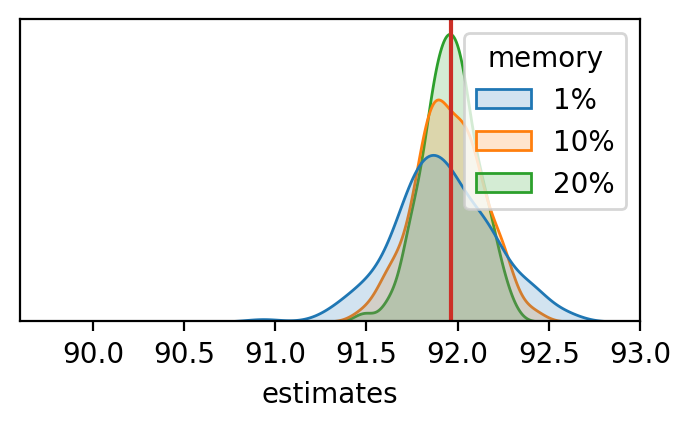

In [34]:
N=200
compare_mem(state_matrix_l, transition_l, emission_l, x_lens_l, N, xlim=[89.6, 93])

## TopK Comparison

100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


bias:
-1.9684906005859375 -0.9950027465820312 -0.06612034606934003 -0.030065979003907728 -0.01307400512695267 0.00016667175293605396
variance:
0.14179714519538242 0.06631768427714332 0.04673311497710553 0.007850133269226877
mse
3.874955244595185 0.9900304657057859 0.14616904535971117 0.06722164737060667 0.046904044587165114 0.0078501610487001


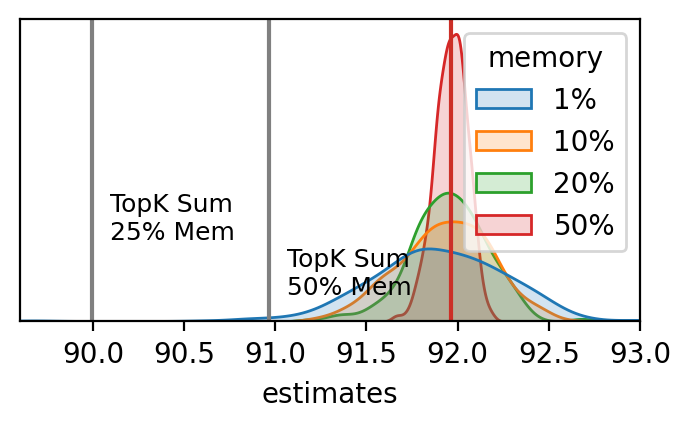

In [60]:
N=500
compare_topk(state_matrix_l, transition_l, emission_l, x_lens_l, N, xlim=[89.6, 93])

## Compare Proposal

100%|██████████| 200/200 [00:04<00:00, 42.26it/s]


bias:
-0.40533676147461506 -1.5384963226318291 -0.2694935226440407 -0.010960464477534515
variance:
0.49152918333304113 0.5410684471761285 0.38052522772759984 0.02827718553353916
mse
0.6558270735357655 2.9080393819278108 0.4531519864746951 0.028397317315102553


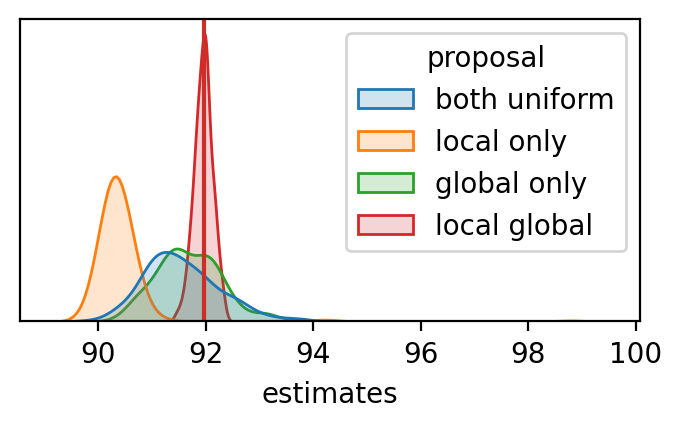

In [68]:
N=200
compare_proposal(state_matrix_l, transition_l, emission_l, x_lens_l, N)

## Compare K1 v.s. K2

100%|██████████| 2000/2000 [01:04<00:00, 31.15it/s]


bias:
-0.040264148712154224 0.049574092864986596 0.031428710937504434 0.018817668914792307 -1.3768633956909184
variance:
0.06851361466234049 0.2704759764855902 0.1448209349844968 0.1280860624039237 0.03429544583870326
mse
0.07013481633385527 0.2729335671689769 0.14580869885568973 0.12844016706731054 1.9300482562322285


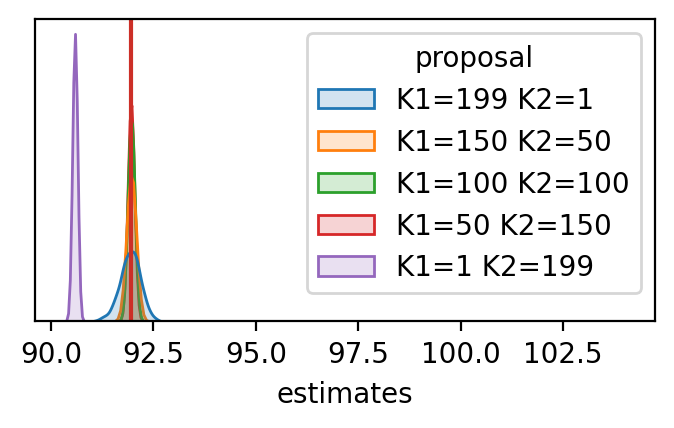

In [36]:
N = 2000
K1 = [199, 150, 100, 50, 1]
K2 = [1, 50, 100, 150, 199]
compare_proposal(state_matrix_l, transition_l, emission_l, x_lens_l, K1, K2, N)

100%|██████████| 10000/10000 [05:20<00:00, 31.21it/s]


bias:
-0.03777781753539955 0.039167966461178594 0.04783139419555482 0.019738869476313425 -1.3788718452453566
variance:
0.07672119313934708 0.17752589888431938 0.2413657055409979 0.13426188166275901 0.009769735540537498
mse
0.0781483566370851 0.17906002848102362 0.24365354781168863 0.13465150463096215 1.9110573011508851


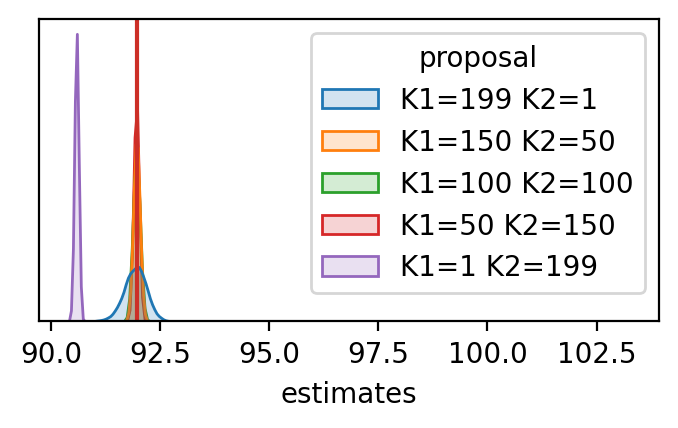

In [37]:
N = 10000
K1 = [199, 150, 100, 50, 1]
K2 = [1, 50, 100, 150, 199]
compare_proposal(state_matrix_l, transition_l, emission_l, x_lens_l, K1, K2, N)

----------

# Middle Level Entropy

## Memory Budget

100%|██████████| 200/200 [00:04<00:00, 44.80it/s]


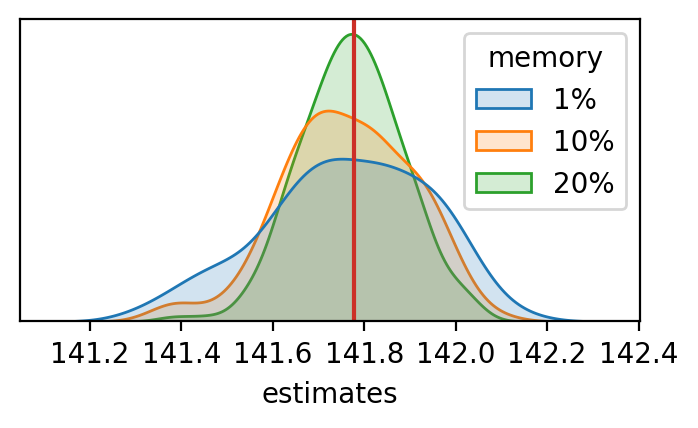

In [33]:
N=200
compare_mem(state_matrix_m, transition_m, emission_m, x_lens_m, N)

## TopK

100%|██████████| 200/200 [00:11<00:00, 17.89it/s]


bias:
-1.0079498291015625 -0.501068115234375 -0.026485900878896018 -0.03129257202147073 -0.01517738342283792 -0.006728210449210792
variance:
0.0661809267340228 0.03234248416868504 0.01978745125764399 0.00407723342217505
mse
1.015962857985869 0.2510692561045289 0.06688242967939004 0.03332170923240483 0.020017804225208238 0.004122502238024026


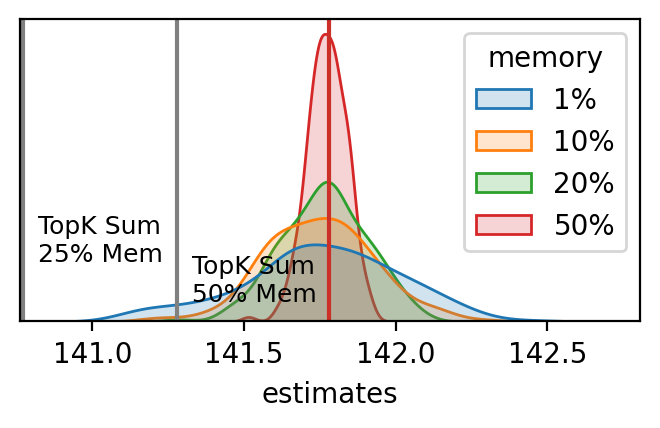

In [61]:
N=200
compare_topk(state_matrix_m, transition_m, emission_m, x_lens_m, N, yloc=0.1, offset=0.05)

## Proposal

100%|██████████| 200/200 [00:04<00:00, 42.19it/s]


bias:
-3.288614120483402 -2.8571153259277366 -0.07726448059082713 -0.010178146362306961
variance:
0.24322662614210855 1.0080273452941098 0.09014934332318955 0.017244285250495886
mse
11.058209459584905 9.171135330945253 0.09611914328415878 0.017347879913868384


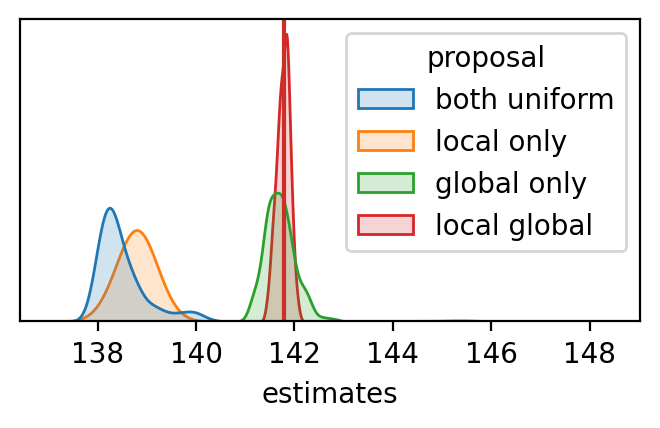

In [71]:
N=200
compare_proposal(state_matrix_m, transition_m, emission_m, x_lens_m, N)

## Compare K1 v.s. K2

100%|██████████| 2000/2000 [01:03<00:00, 31.26it/s]


bias:
-0.0136636276245099 0.02000943756104334 0.032629661560065415 0.011779617309571222 -6.590625778198245
variance:
0.035575578716667305 0.08823784734469785 0.1552717633583103 0.0887137931615298 0.000573368962853914
mse
0.03576227343652863 0.08863822493620682 0.15633645817183422 0.08885255254548974 43.43692151721404


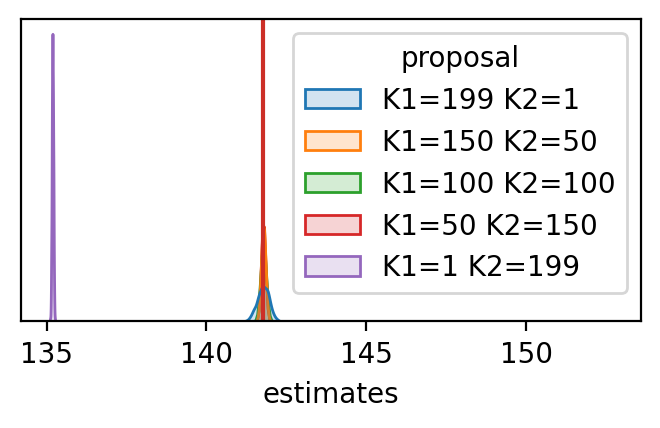

In [39]:
N = 2000
K1 = [199, 150, 100, 50, 1]
K2 = [1, 50, 100, 150, 199]
compare_proposal(state_matrix_m, transition_m, emission_m, x_lens_m, K1, K2, N)

--------

# Small Level Entropy

## Memory

100%|██████████| 500/500 [00:11<00:00, 44.85it/s]


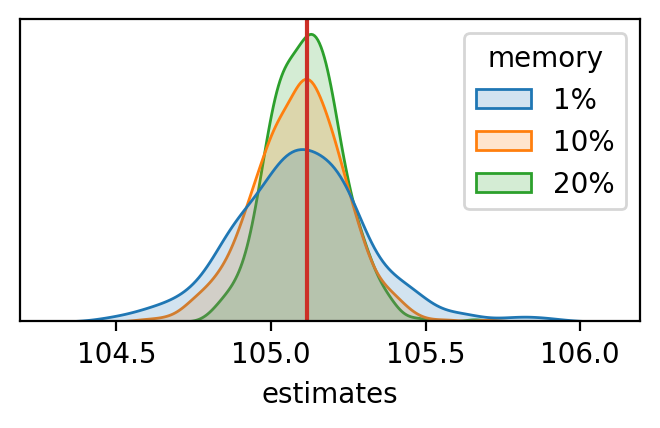

In [64]:
N=500
compare_mem(state_matrix_s, transition_s, emission_s, x_lens_s, N)

## topk

100%|██████████| 200/200 [00:11<00:00, 17.94it/s]


bias:
-0.4035491943359375 -0.177459716796875 -0.05024501800536996 -0.02794902801514354 -0.0031256484985391353 -0.00869411468505632
variance:
0.074065700935536 0.05443875010607153 0.02645111033726571 0.004516729695429967
mse
0.16285195224918425 0.03149195108562708 0.07659026276989607 0.05521989827306242 0.026460880015802105 0.004592317325586919


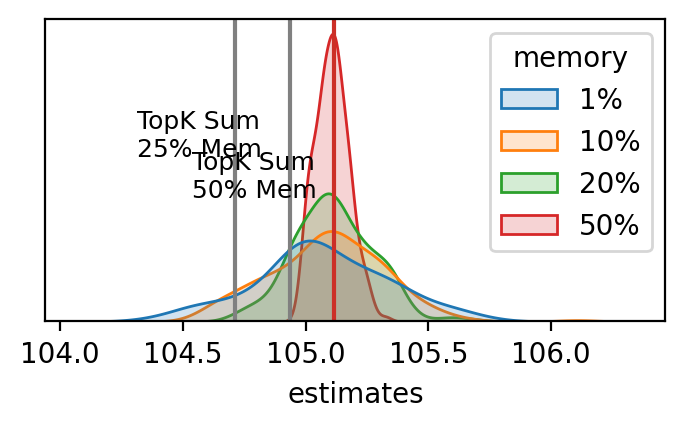

In [62]:
N=200
compare_topk(state_matrix_s, transition_s, emission_s, x_lens_s, N, yloc=0.6, offset=-0.4)

## Proposal

100%|██████████| 200/200 [00:04<00:00, 41.00it/s]


bias:
-0.07071247100830647 -0.48204780578613793 -0.03013778686523949 -0.01244243621826513
variance:
0.1550878454706617 0.24931258479069804 0.09946019326404203 0.02205842429445911
mse
0.1600880990267615 0.4816826718539232 0.10036847946117632 0.02221323851350462


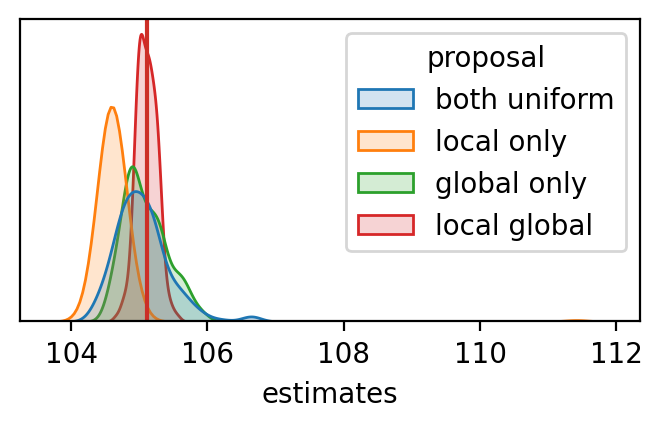

In [74]:
N=200
compare_proposal(state_matrix_s, transition_s, emission_s, x_lens_s, N)

## Compare K1 v.s. K2

100%|██████████| 2000/2000 [01:04<00:00, 31.24it/s]


bias:
-0.016551021575921254 0.005588912963872872 0.003338840484616412 0.009636089324956743 -2.3339659271240265
variance:
0.04652333922320393 0.0329942500103789 0.0691050360338115 0.08039112558623532 0.0004941039217098151
mse
0.04679727553841076 0.033025485958496574 0.06911618388959323 0.08048397980371373 5.447891052897612


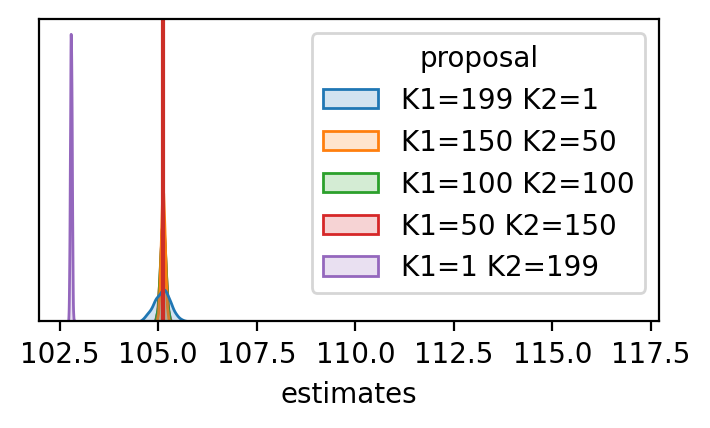

In [40]:
N = 2000
K1 = [199, 150, 100, 50, 1]
K2 = [1, 50, 100, 150, 199]
compare_proposal(state_matrix_s, transition_s, emission_s, x_lens_s, K1, K2, N)